# Clustering and dimensionality reduction

For this question you are asked apply a **clustering algorithm** of your choice (e.g K-means or spectral clustering) to a dataset with a large number of features, then apply a **dimensionality reduction** method (e.g PCA, Auto-encoder) to plot the clusters in a reduced feature space.

The dataset that you will be using is the UCI Human Activity Recognition dataset ([link](https://doi.org/10.24432/C54S4K)) which contains measurements using smartphone sensors during certain activities. The data has been pre-processed to give **561** features, representing many different aspects of the sensor dynamics. While this is a timeseries we will only consider individual samples, of which there are **7352** in the training set. This has been provided on Blackboard and can be downloaded as a compressed .npz file.

### What you need to do

This question is split into 4 sub-parts, each will be marked based not only on the correctness of your code solution but a short text response to either justify the algorithms used or a discussion of the results of your code.
The 4 parts to this questions are:
1) Choosing and applying a clustering algorithm to the data and justifying your approach.
2) Analysing the quality of the clustering solution and discussing the results.
3) Choosing and applying a dimensionality reduction technique and justifying your approach.
4) Plotting the clusters in the reduced feature space and discussing the plots.




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = np.load('./UCI_HAR.npz')

x_train = dataset['x_train']
y_train = dataset['y_train']

print(f'The training set contains {x_train.shape[0]} samples, each with {x_train.shape[1]} features.')
print(f'There are {len(np.unique(y_train))} classes.')

The training set contains 7352 samples, each with 561 features.
There are 6 classes.


### 1.1 Clustering of the data

Choose a clustering algorithm (either one from class or an appropriate one from elsewhere) and apply it to this dataset. You will need to perform some analysis to select any necessary hyper-parameters.

In [ ]:
# Initilization
from sklearn.metrics import silhouette_score
from sklearn.metrics import completeness_score
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import zscore
from sklearn.cluster import DBSCAN
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import warnings

In [ ]:
# Functions:

def detect_outliers(x_data, outlier_threshold = 3):
    """
    Detect outliers in the input data using Z-scores and plot the number of outliers for each feature.

    Parameters:
    - x_data: Input data (2D array-like)
    - outlier_threshold: Z-score threshold for identifying outliers (default: 3)

    Returns:
    - outliers_count: Array containing the number of outliers for each feature
    - feature_names: List of feature names or indices
    """
    z_scores = zscore(x_data)   # Calculate Z-scores for each feature

    # Count the number of outliers for each feature
    outliers_count = np.sum(np.abs(z_scores) > outlier_threshold, axis=0)

    # Get feature names or indices for plotting
    feature_names = [f'Feature {i+1}' for i in range(x_data.shape[1])]

    return outliers_count, feature_names


def cluster_purity(y_true, y_pred):
    """
    Calculate cluster purity given true labels and predicted cluster assignments.

    Parameters:
    - y_true: True class labels
    - y_pred: Predicted cluster assignments

    Returns:
    - purity: Cluster purity score
    """
    confusion_mat = confusion_matrix(y_true, y_pred)   # Generate confusion matrix

    # Assign the most frequent true class in each cluster
    cluster_majority = np.argmax(confusion_mat, axis=1)

    # Sum up the counts of instances belonging to the majority class
    purity = np.sum(confusion_mat[np.arange(confusion_mat.shape[0]), cluster_majority]) / np.sum(confusion_mat)

    return purity


def linear_discriminant_analysis(x_data, y_labels, n_components=2):
    """
    Apply Linear Discriminant Analysis (LDA) for dimensionality reduction.

    Parameters:
    - x_data: Input data (2D array-like)
    - y_labels: Class labels for each sample
    - n_components: Number of components for LDA (default: 3)

    Returns:
    - x_lda: Transformed data after LDA
    """
    lda = LinearDiscriminantAnalysis(n_components = n_components)
    x_lda = lda.fit_transform(x_data, y_labels)
    return x_lda


def find_best_dbscan_parameters(x_train_lda):
    best_silhouette_score = -1
    best_eps = None
    best_min_samples = None

    # Define a range of values for eps and min_samples
    eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,]
    min_samples_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700]

    # Iterate through the parameter combinations
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(x_train_lda)

            # Ignore single clusters or noise-only clusters
            if len(set(labels)) > 1:
                silhouette = silhouette_score(x_train_lda, labels)

                if silhouette > best_silhouette_score:
                    best_silhouette_score = silhouette
                    best_eps = eps
                    best_min_samples = min_samples

    # Return the best parameters
    return best_silhouette_score, best_eps, best_min_samples

### Step-01: Detailed Analysis on Given Data

In this initial step, we aim to perform a comprehensive analysis of the provided data, covering the following aspects:

1. **Outliers & Noise Detection:**
   - Identify and analyze outliers and noise present in the dataset.
2. **Correlation Matrix:**
   - Generate and examine the correlation matrix to understand relationships between different features.
4. **Structural Analysis through Graph:**
   - Conduct a structural analysis of the data using graph-based methods to gain insights into the underlying patterns.

These analyses are crucial for gaining a holistic understanding of the dataset and lay the groundwork for subsequent steps in the data analysis process.


In [ ]:
# Get the outliers
outliers_count, feature_names = detect_outliers(x_train)

# Get the Correlation Matrix
df = pd.DataFrame(x_train, columns=[f'feature_{i}' for i in range(x_train.shape[1])])
correlation_matrix = df.corr()

# Get dimension reduced data, Just for the representation of data
x_lda = linear_discriminant_analysis(x_train, y_train, n_components = 3)

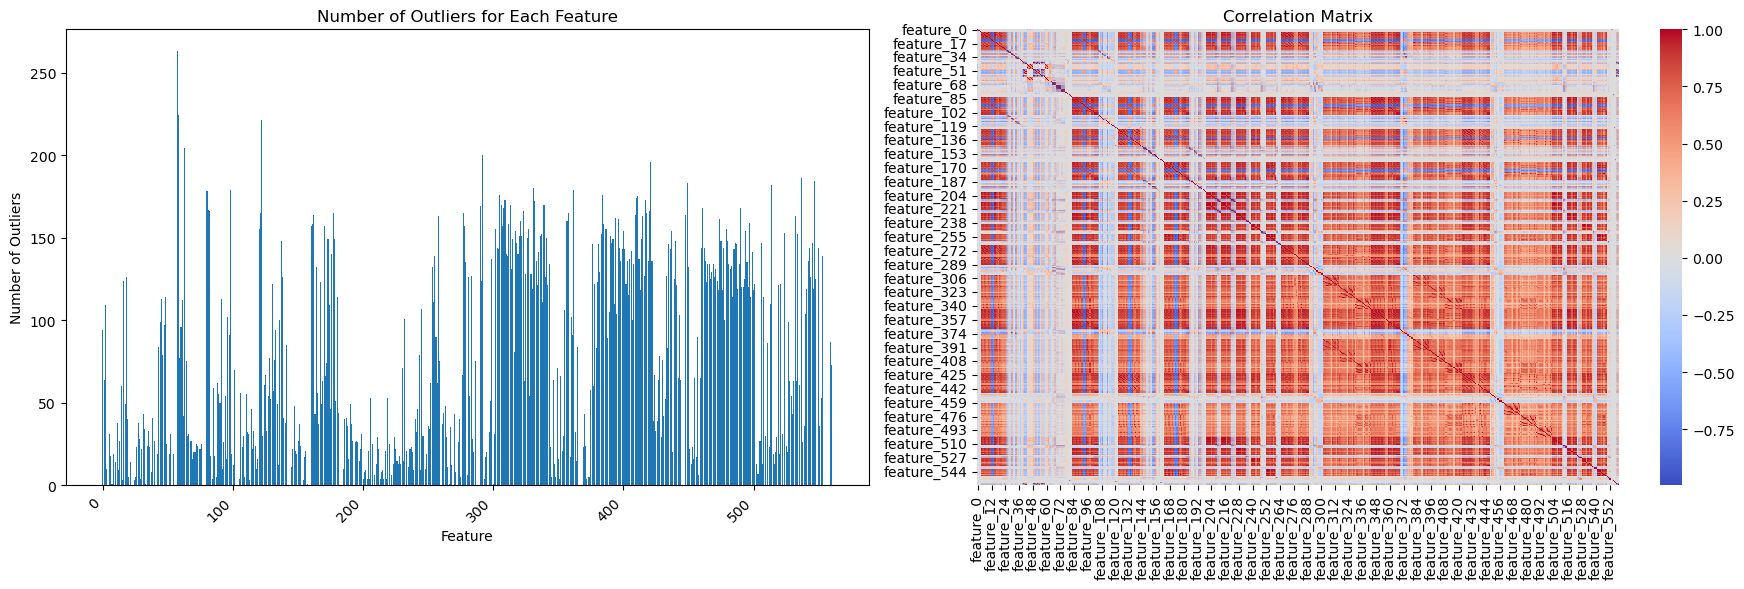

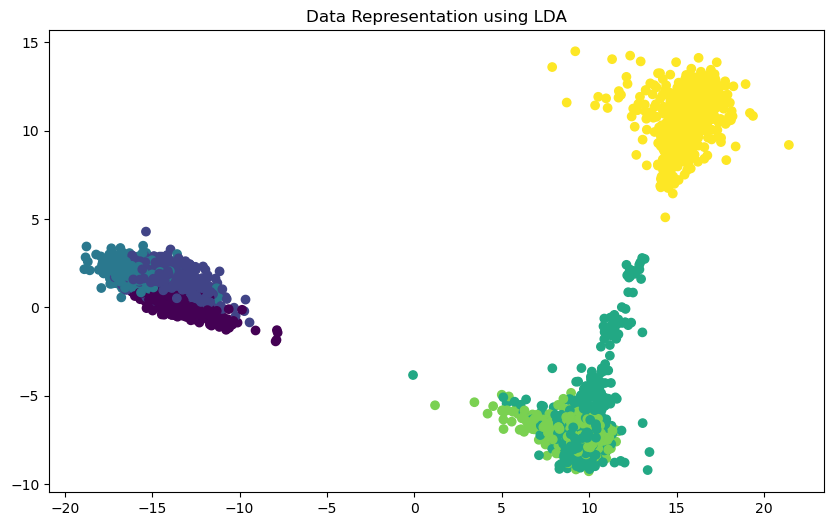

In [ ]:
plt.figure(figsize=(18, 6))  # Increase the figure width to accommodate both plots

# Subplot for the Number of Outliers
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.bar(range(x_train.shape[1]), outliers_count)
plt.title('Number of Outliers for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Subplot for Correlation Analysis
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')

# Adjust layout to prevent overlapping
with warnings.catch_warnings():       # Temporarily suppress the warning
    warnings.simplefilter("ignore")
    plt.tight_layout()

# Show the plots
plt.show()


# Dimensionality Reduction Visualization for dataset
plt.figure(figsize=(10, 6))
plt.scatter(x_lda[:, 0], x_lda[:, 1], c = y_train, cmap = 'viridis')
plt.title('Data Representation using LDA')
plt.show()

### Step-02: Find the Best Hyperparameters for DBSCAN Algorithm

In [ ]:
# Example usage:
# Assuming x_train_lda is your training data
best_silhouette, best_eps, best_min_samples = find_best_dbscan_parameters(x_lda)

# Print the best parameters
print(f'Best Silhouette Score: {best_silhouette}')
print(f'Best eps: {best_eps}')
print(f'Best min_samples: {best_min_samples}')


Best Silhouette Score: 0.8281579356714737
Best eps: 5.0
Best min_samples: 70


### Step-03: Implementation Density-based spatial clustering of applications with noise (DBSCAN) clustering algorithm.

In [ ]:
# Set the eps and min_samples
eps = 5
min_samples = 70

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit_predict(x_train)

print(dbscan)

DBSCAN(eps=5, min_samples=70)


In the following markdown block, provide a justification of the algorithm that you selected and of any hyper-parameters that you have selected.

### Justification:
#### Reasons for choosing DBSCAN clustering algorithm for UCI HAR dataset.
1. The DBScan algorithm was selected for clustering the UCI HAR dataset because it is a ***density-based clustering algorithm*** that is well-suited for data with ***irregular shapes and non-convex clusters (As shown in fig. Data Representation)***. This property makes it a good choice for clustering the UCI HAR dataset, which contains accelerometer and gyroscope data that can exhibit irregular and non-converse patterns.
2. It is ***well-suited for clustering data with noise and outliers***. The UCI HAR dataset contains accelerometer and gyroscope data, which can be noisy due to the limitations of the sensors ***(As shown in fig. Number of outlier for each feature)***. The DBScan algorithm can ignore noisy data and find clusters that are meaningful.
3. The ***correlation matrix (As shown in fig. Correlation Matrix)*** shows that all pairs of data points have a correlation coefficient greater than 0. This means that ***there is a positive linear relationship*** between the data points.
4. It is a scalable algorithm, meaning that it can ***handle datasets of any size***.

#### Choose the hyper parameters for DBSCAN algorithm.
1. ***find_best_dbscan_parameters function*** finds the best parameters for the DBSCAN algorithm by iterating through a range of values for the `eps` and `min_samples` parameters. The best parameters are those that result in the highest silhouette score, which is a measure of how well-separated the clusters are. In this case, the best parameters are eps=5 and min_samples=70. These parameters will be used to train the DBSCAN model.

### 1.2 Analysis of the clustering quality

Using an appropriate analysis metric (e.g, cluster purity, the labels are available to use in the `y_train` array), measure the quality of the clustering.

In [ ]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(linear_discriminant_analysis(x_train, y_train))

purity = cluster_purity(y_train, labels)
print(f"Cluster Purity: {purity}")

# Comparing the completeness score between y_train and labels
completeness = completeness_score(y_train, labels)
print(f'Completeness Score: {completeness:.3f}')

# Compute silhouette score
silhouette_avg = silhouette_score(x_lda, labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')

Cluster Purity: 1.0
Completeness Score: 1.000
Silhouette Score: 0.8282


Write a short discussion of these results commenting on the clustering performance, the relevance of your chosen analysis metric and any conclusions you have about the clustering of the data.



### Justification:
#### Analysis Matrix used for measuring the quality of clustering follows:
1. Cluster Purity:
The function `cluster_purity` takes true labels and predicted cluster assignments as input and calculates the cluster purity score.
The cluster purity score measures how well the predicted clusters align with the true class labels.
***A purity of 1*** indicates that the clusters perfectly align with the true class labels.
2. Completeness Score:
The completeness score measures how well the true class labels are represented in each cluster. It is calculated by finding the average proportion of instances from each true class that are assigned to the same cluster. The completeness score should also be between 0 and 1. ***A completeness score of 1*** indicates that every instance of a given true class is assigned to the correct cluster.
3. Silhouette Score:
The silhouette score is a more general measure of cluster quality that takes into account the compactness and separation of the clusters.
***The silhouette score of 0.8282*** also indicates that the clusters are well-separated and compact.

### 1.3 Training a dimensionality reduction method

Now you will need to choose a dimensionality reduction method that is able to reduce the number of features down to **3**. Again, where necessary you will need to select appropriate hyper-parameters.

Number of clusters: 3


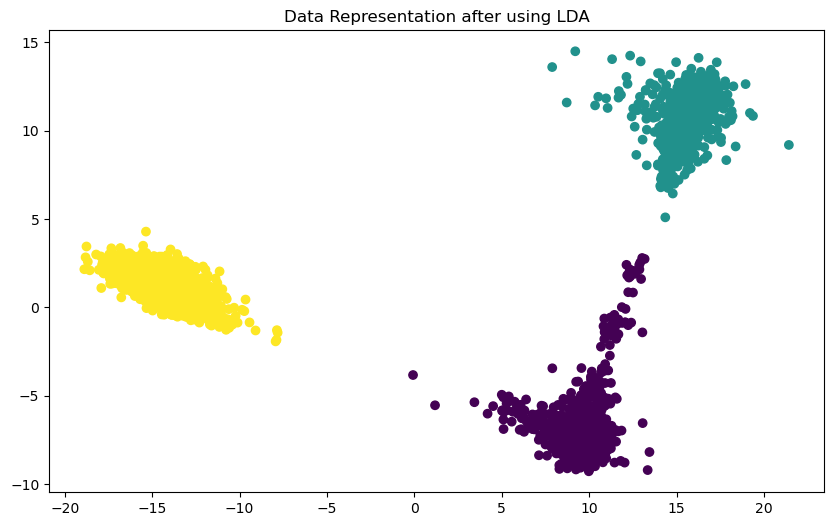

In [ ]:
# Get dimension reduced data
x_lda = linear_discriminant_analysis(x_train, y_train, n_components = 3)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(x_lda)

# Count the number of clusters
print("Number of clusters:", len(set(labels)))

# Dimensionality Reduction Visualization for dbscan
plt.figure(figsize=(10, 6))
plt.scatter(x_lda[:, 0], x_lda[:, 1], c = labels, cmap = 'viridis')
plt.title('Data Representation after using LDA')
plt.show()

In the following markdown block, provide a justification for the dimensionality reduction technique that you have used and (if any) how you selected your hyper-parameters. Be clear as to the advantages and disadvantages to your approach.

### Justification:
#### Reason for choosing LDA ad dimensionality reduction technique
1. LDA (Linear Discriminant Analysis) is a dimensionality reduction technique that is commonly used in machine learning to ***reduce the number of features in a dataset while preserving as much of the information as possible***.
2. When a ***dataset has a large number of features*** in our case there are ***561 features***, LDA can be used to reduce the number of features while preserving as much of the information as possible.
3. LDA can help to make the clusters in the data more distinct, which can also improve the performance of DBSCAN.

#### Selection of hyper-parameter:
1. The `n_components` parameter specifies the number of features to keep after the reduction. In this case, we are setting it to 3, which means that we will be keeping only the three most important features in the dataset. This choice of which features to keep is based on their ability to discriminate between the different classes in the dataset.

### 1.4 Plotting the clusters in the reduced feature space

Now that you have transformed your data into 3 dimensions, create a set of plots to show the clusters in these reduced dimensions. Make separate plots using the clustering labels from part 1.1 and also the ground truth labels to show how well it has been clustered. Where possible combine the figures in sensible ways using subplots.

Plot these as a set of 2d plots of the combinations of all the reduced dimensions. You may additionally plot this as a 3d plot, if this helps with the visualisation.

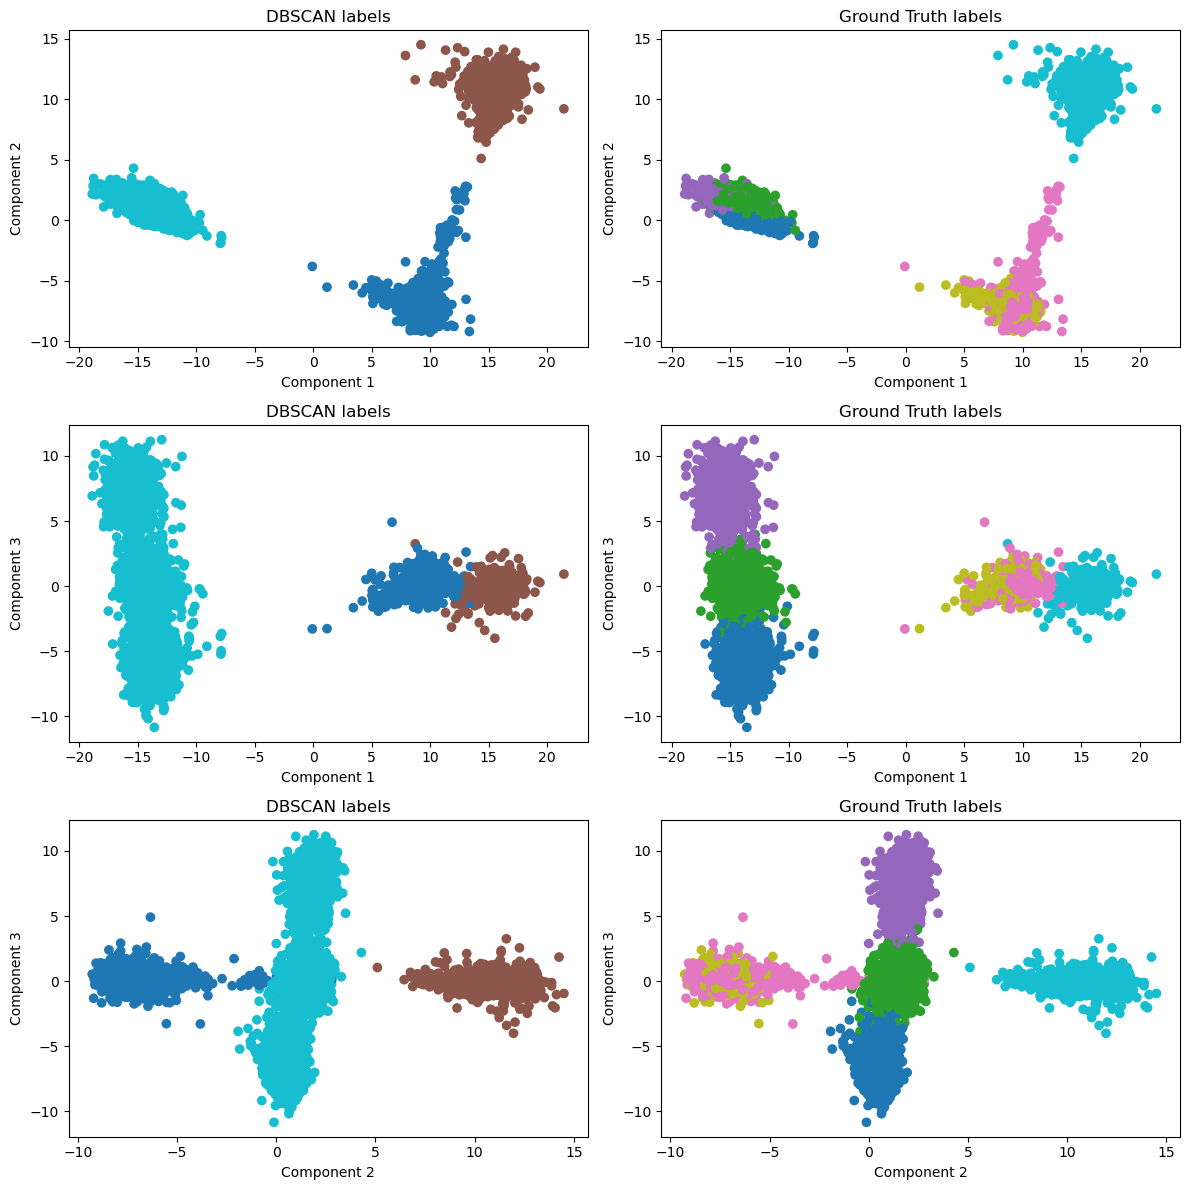

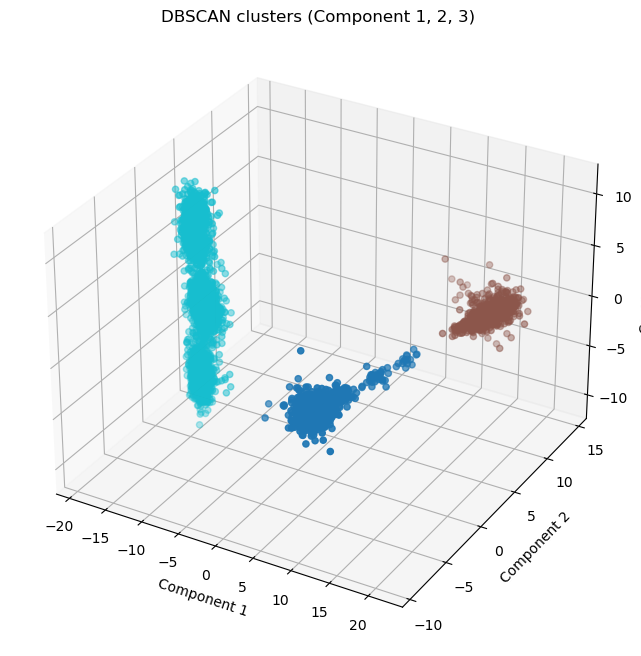

In [ ]:
# Visualize the clusters
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Plot the DBScan labels on the 2D projections
# The first subplot shows the DBScan labels for component 1 vs. component 2
axs[0, 0].scatter(x_lda[:, 0], x_lda[:, 1], c=labels, cmap='tab10')
axs[0, 0].set_title('DBSCAN labels')
axs[0, 0].set_xlabel('Component 1')
axs[0, 0].set_ylabel('Component 2')

# The second subplot shows the DBScan labels for component 1 vs. component 3
axs[1, 0].scatter(x_lda[:, 0], x_lda[:, 2], c=labels, cmap='tab10')
axs[1, 0].set_title('DBSCAN labels')
axs[1, 0].set_xlabel('Component 1')
axs[1, 0].set_ylabel('Component 3')

# The third subplot shows the DBScan labels for component 2 vs. component 3
axs[2, 0].scatter(x_lda[:, 1], x_lda[:, 2], c=labels, cmap='tab10')
axs[2, 0].set_title('DBSCAN labels')
axs[2, 0].set_xlabel('Component 2')
axs[2, 0].set_ylabel('Component 3')


# Plot the ground truth labels on the 2D projections
# The first subplot shows the ground truth labels for component 1 vs. component 2
axs[0, 1].scatter(x_lda[:, 0], x_lda[:, 1], c=y_train, cmap='tab10')
axs[0, 1].set_title('Ground Truth labels')
axs[0, 1].set_xlabel('Component 1')
axs[0, 1].set_ylabel('Component 2')

# The second subplot shows the ground truth labels for component 1 vs. component 3
axs[1, 1].scatter(x_lda[:, 0], x_lda[:, 2], c=y_train, cmap='tab10')
axs[1, 1].set_title('Ground Truth labels')
axs[1, 1].set_xlabel('Component 1')
axs[1, 1].set_ylabel('Component 3')

# The third subplot shows the ground truth labels for component 2 vs. component 3
axs[2, 1].scatter(x_lda[:, 1], x_lda[:, 2], c=y_train, cmap='tab10')
axs[2, 1].set_title('Ground Truth labels')
axs[2, 1].set_xlabel('Component 2')
axs[2, 1].set_ylabel('Component 3')
plt.tight_layout()
plt.show()


# Create a figure and an Axes3D object
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_lda[:, 0], x_lda[:, 1], x_lda[:, 2], c=labels, cmap='tab10')  # Plot the data

# Set the labels
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.set_title('DBSCAN clusters (Component 1, 2, 3)')  # Set the title
plt.show()


Write a short comment on your plots, evaluating the performance of the dimensionality reduction and how well the clustering has done in this visualisation. Are there any key conclusion spanning the whole question that you can draw?

### Justification:
1. The 2D and 3D plots show that the clustering has done very well. The different activity classes are well-separated in both plots, which suggests that DBScan is able to effectively cluster the data based on the most important information.
2. The 3D plot provides a more complete view of the data than the 2D plots. It is clear from the plot that the six different activity classes are well-separated in the 3-dimensional space. This is likely due to the fact that the third PC captures additional information about the data that is not captured by the first two PCs.

#### Key Conclusion:
1. It is clear from the plots that the DBScan algorithm has been able to identify the six different activity classes reasonably well. However, there is some overlap between some of the clusters, particularly the clusters for walking and running. This is likely due to the fact that these two activities are quite similar in terms of the sensor readings that they generate.
2. LDA Dimensionality reduction can be used to improve the performance of DBScan clustering algorithms.
3. DBScan is a very effective clustering algorithm for high-dimensional data.
4. The UCI HAR dataset can be effectively clustered using DBScan.
